<a href="https://colab.research.google.com/github/REXWindW/study_notes/blob/main/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# transformers库+pytorch实现RNN情感分类
- 参考博客：
- https://blog.csdn.net/weixin_40605573/article/details/113140270
- https://jinhanlei.github.io/posts/Transformers%E5%BF%AB%E9%80%9F%E5%85%A5%E9%97%A8-%E5%9B%9B-%E7%BB%93%E5%90%88Transformers%E5%92%8CPyTorch%E4%BF%AE%E6%94%B9%E6%A8%A1%E5%9E%8B/

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.1 MB/s eta 0:00:00


In [3]:
!unzip test.tsv.zip
!unzip train.tsv.zip

Archive:  test.tsv.zip
  inflating: test.tsv                
Archive:  train.tsv.zip
  inflating: train.tsv               


In [2]:
import torch

import random
import numpy as np

SEED = 1101

# 固定随机种子
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# 用bert tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 定义一些特殊符
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

# 发现包含开始和结束符号
tokenizer('genshin,start!'),tokenizer('hello world')

({'input_ids': [101, 8991, 17426, 1010, 2707, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]},
 {'input_ids': [101, 7592, 2088, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]})

In [5]:
tokenizer.convert_tokens_to_ids(
    tokenizer.tokenize('genshin,start!')
    )
# 取里面的id

[8991, 17426, 1010, 2707, 999]

In [6]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
def tokenize_and_cut(sentence): # 限制最大长度为512，并且留两个来存开始和结束
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    return tokens

In [7]:
import pandas as pd

# 用read_csv函数读取.tsv文件，指定分隔符为制表符
df_train = pd.read_csv('train.tsv', sep='\t')
df_test = pd.read_csv('test.tsv',sep='\t')
df_train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [8]:
df_train.isnull().any()
# 检查发现没有空值

PhraseId      False
SentenceId    False
Phrase        False
Sentiment     False
dtype: bool

In [9]:
df_train.drop_duplicates(subset=["SentenceId"], keep="first")
# 去除重复行

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1
...,...,...,...,...
155984,155985,8540,... either you 're willing to go with this cla...,2
155997,155998,8541,"Despite these annoyances , the capable Claybur...",2
156021,156022,8542,-LRB- Tries -RRB- to parody a genre that 's al...,1
156031,156032,8543,The movie 's downfall is to substitute plot fo...,1


<Axes: >

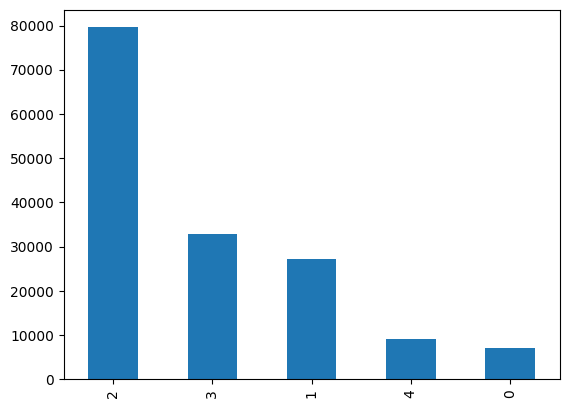

In [10]:
df_train["Sentiment"].value_counts().plot(kind="bar")
# pandas居然自带画图

In [11]:
#对句子进行tokenize
seq_len = 512
tokens = tokenizer(df_train["Phrase"].tolist(),
                  max_length=seq_len,
                  truncation=True,
                  padding="max_length",
                  add_special_tokens=True, # the sequences will be encoded with the special tokens relative to their model
                  return_tensors="np")

In [12]:
tokens

{'input_ids': array([[  101,  1037,  2186, ...,     0,     0,     0],
       [  101,  1037,  2186, ...,     0,     0,     0],
       [  101,  1037,  2186, ...,     0,     0,     0],
       ...,
       [  101, 20704,  4609, ...,     0,     0,     0],
       [  101, 20704,  4609, ...,     0,     0,     0],
       [  101, 16480,  5339, ...,     0,     0,     0]]), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}

In [13]:
num_train = df_train.shape[0]
# 把label变成onehot encoding
label = np.zeros((num_train,5))
label.shape

(156060, 5)

In [14]:
for index, row in df_train.iterrows():
    label[index][row['Sentiment']] = 1
    # 变成onehot encoding
label[:5]

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [15]:
# 定义一下dataset
from torch.utils.data import Dataset, DataLoader

input_ids = torch.tensor(tokens['input_ids'])# transformers.batchencoding到tensor
labelt = torch.tensor(label)
attm = torch.tensor(tokens['attention_mask'])
# 这里根据gpt的指导，把transfomers库的类型转化成tensor再读入

class MyDataset:
    def __init__(self,inpt,am,lb):
        # 一般通过文件读入
        # self.df = pd.read_csv(filename)
        # 这里直接导入先前处理过的df
        self.input_ids = inpt
        self.attention_mask = am
        # attention mask是必要的，不然dataset里面每个元素的长度都会变成和最长的一样，剩余部分用0填充
        self.label = lb

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self,idx):
        return {
            # 发现他们return都是这么给的
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'label': self.label[idx]
        }

# 创建dataset
ds = MyDataset(input_ids,attm,labelt)

# 创建dataloader
batch_size = 32
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [16]:
#测试一下dataset
ds[10]

{'input_ids': tensor([  101, 14313,  1996, 15262,  3351,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [17]:
ds[10]['input_ids'].shape, ds[10]['attention_mask'].shape # 发现长为512，符合要求

(torch.Size([512]), torch.Size([512]))

In [18]:
from transformers import BertTokenizer, BertModel
bert = BertModel.from_pretrained('bert-base-uncased')
# 使用bert预训练权重

In [19]:
import torch.nn as nn

class Bertbase_model(nn.Module):
    def __init__(self,
                 bertm,
                 hidden_dim, # 隐藏层
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout
                 ):
        super().__init__()
        self.bert = bertm
        embedding_dim = self.bert.config.to_dict()['hidden_size'] # 得到bert的隐藏层维度

        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)# RNN

        # 输出层我使用一个MLP
        self.out1 = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, 1024)
        self.out2 = nn.Linear(1024, output_dim)
        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(dropout)

    # 这里需要修改一下forward，让他支持attentionmask!
    def forward(self,text,tmask):
        with torch.no_grad():
            embedded = self.bert(input_ids=text, attention_mask=tmask)[0] # bert嵌入部分不计算梯度

        # 使用rnn处理
        # 这里RNN返回值是RNN输出和隐状态H，我们取隐状态进行后续处理
        _, hidden = self.rnn(embedded)

        # dropout
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        # 改成通过MLP输出
        mlp_hidden = self.out1(hidden)
        # 中间加一个relu
        relud = self.relu(mlp_hidden)
        output = self.out2(relud)

        # 增加一个softmax
        output_probs = torch.softmax(output, dim=1)
        return output_probs

In [20]:
# 设置模型参数
HIDDEN_DIM = 256
OUTPUT_DIM = 5 # 输出五个维度，取最大的
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = Bertbase_model(bert,
                       HIDDEN_DIM,
                       OUTPUT_DIM,
                       N_LAYERS,
                       BIDIRECTIONAL,
                       DROPOUT)


In [21]:
# 看一下参数量=
tot = 0
for p in model.parameters():
    if p.requires_grad:
        tot+=p.numel() # 统计trainable参数数量

print(f"the number of trainable param is {tot}")

the number of trainable param is 112771333


In [22]:
# 打印一下参数，冻结bert相关参数

for name,p in model.named_parameters():
    print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [23]:
# 博客的方法是建议冻结bert的所有参数，只训练后续的RNN
for name,p in model.named_parameters():
    if name.startswith('bert'):
        p.requires_grad = False
# 再统计一下trainable参数
tot = 0
for name,p in model.named_parameters():
    if p.requires_grad:
        print(name)
        tot+=p.numel() # 统计trainable参数数量

print(f"the number of trainable param is {tot} after froze bert")

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out1.weight
out1.bias
out2.weight
out2.bias
the number of trainable param is 3289093 after froze bert


In [24]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters()) # adam优化器
criterion = nn.BCEWithLogitsLoss() # 二元交叉熵损失

In [25]:
# move to gpu
device = torch.device('cuda:0')

model = model.to(device)
criterion = criterion.to(device)
# 一开始只把model和criterion放到device
# 报错说有些东西在gpu上有些在cpu上，查阅资料后发现数据

In [26]:
def cal_accuracy(pred_y, real_y):
    pred_lab = torch.argmax(pred_y,dim=1) # 对应第一个维度是batch
    # argmax是会改变维度的，比如[0.1, 0.1, 0.8, 0.0]变成[2]
    # 所以这里我考虑对答案label也做一个argmax使维度统一
    real_lab = torch.argmax(real_y,dim=1)

    correct = (pred_lab==real_lab)# 这里对应位置相同的地方为1
    count = correct.sum().item() # 统计这些1的数量

    return count/len(pred_lab)

In [27]:
from tqdm import tqdm

In [40]:
#             'input_ids': self.input_ids[idx],
#             'attention_mask': self.attention_mask[idx],
#             'label': self.label[idx]
# 前面dataset的返回值格式
def train(model, dtld, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    # 使用tqdm显示进度条
    loop = tqdm(dtld, desc='Train', position=0)

    for batch in loop: # dataloader
        optimizer.zero_grad()

        # 在这里把数据移动到gpu上
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['label'].to(device)

        predictions = model(input_ids, attention_mask)

        # calculate loss and accuracy
        loss = criterion(predictions,  label)
        acc = cal_accuracy(predictions, label)

        # update model
        loss.backward()
        optimizer.step()

        # 更新训练信息
        loop.set_description(f'Epoch [{epoch+1}/{N_EPOCH}]')
        loop.set_postfix(loss = loss.item() , acc = acc)

        # get sum
        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss / len(dtld), epoch_acc / len(dtld)

In [35]:
# 统计时间
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [41]:
N_EPOCH = 5 # 训练5个epoch

# 开始训练
for epoch in range(N_EPOCH):
    start_time = time.time()
    train_loss, train_acc = train(model, dataloader, optimizer, criterion)
    end_time = time.time()
    print(f"epoch : {epoch+1} , time : {epoch_time(start_time,end_time)}")
    print(f"loss : {train_loss} , acc : {train_acc}")

Epoch [1/5]:   1%|          | 38/4877 [00:47<1:41:44,  1.26s/it, acc=0.594, loss=0.698]


KeyboardInterrupt: ignored